# Decision Trees and Random Forests

### Problem Statement:
Predict next-day rain by training classification models on the target variable RainTomorrow.


We can read the data back preprocessed datasets for training, validation, and testing using `pd.read_parquet`, where the following data preparation steps have been performed:

* Splitting a dataset into training, validation & test sets
* Filling/imputing missing values in numeric columns
* Scaling numeric features to a (0,1) range
* Encoding categorical columns as one-hot vectors

In [1]:
import pandas as pd

In [2]:
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')["RainTomorrow"]
val_targets = pd.read_parquet('val_targets.parquet')["RainTomorrow"]
test_targets = pd.read_parquet('test_targets.parquet')["RainTomorrow"]

In [3]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (9788, 123)
train_targets: (9788,)
val_inputs: (1700, 123)
val_targets: (1700,)
test_inputs: (2591, 123)
test_targets: (2591,)


In [4]:
train_targets

126989     No
40299      No
28288      No
134636     No
130983    Yes
         ... 
50356      No
122446    Yes
49288      No
119280     No
118137     No
Name: RainTomorrow, Length: 9788, dtype: object

In [5]:
test_targets

80721      No
83947     Yes
23750      No
89908      No
93275      No
         ... 
143525     No
93147      No
120606    Yes
39511      No
48783      No
Name: RainTomorrow, Length: 2591, dtype: object

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

In [6]:
train_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
126989,Walpole,0.437824,0.397959,0.031655,0.094322,0.534317,NW,0.190909,WNW,WSW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
40299,Williamtown,0.694301,0.932653,0.000000,0.168966,0.895105,WNW,0.427273,NNW,WNW,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28288,Richmond,0.634715,0.618367,0.000000,0.094322,0.534317,NNE,0.136364,None,NE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
134636,Launceston,0.287565,0.314286,0.021103,0.094322,0.534317,SSW,0.054545,None,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
130983,Hobart,0.297927,0.467347,0.000000,0.048276,0.272727,NW,0.390909,NNW,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50356,Tuggeranong,0.147668,0.373469,0.000000,0.094322,0.534317,W,0.209091,NW,WSW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
122446,Perth,0.461140,0.483673,0.000000,0.058621,0.223776,N,0.236364,N,NW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49288,Tuggeranong,0.386010,0.455102,0.002878,0.094322,0.534317,NNW,0.327273,NNW,NW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
119280,PerthAirport,0.440415,0.538776,0.000000,0.082759,0.699301,NW,0.290909,NNE,W,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [7]:
import numpy as np

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Location_Perth',
 'Location_PerthAirport',
 'Location_Portland',

In [9]:
X_train = train_inputs[numeric_cols]
X_val = val_inputs[numeric_cols]
X_test = test_inputs[numeric_cols]

In [10]:
X_val

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
23480,0.595855,0.504082,0.000959,0.082759,0.517483,0.254545,0.292308,0.197368,0.666667,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
77238,0.461140,0.412245,0.004796,0.003448,0.391608,0.290909,0.261538,0.263158,0.989583,0.757576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20541,0.712435,0.867347,0.000000,0.094322,0.534317,0.572727,0.461538,0.118421,0.468750,0.111111,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
57419,0.251295,0.226531,0.000000,0.094322,0.534317,0.218182,0.338462,0.289474,0.791667,0.757576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44800,0.567358,0.459184,0.254197,0.094322,0.534317,0.236364,0.200000,0.289474,0.927083,0.828283,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,0.321244,0.365306,0.000959,0.094322,0.534317,0.118182,0.000000,0.223684,1.000000,0.737374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5429,0.466321,0.673469,0.000000,0.094322,0.534317,0.154545,0.030769,0.144737,1.000000,0.383838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
83338,0.256477,0.381633,0.000000,0.031034,0.363636,0.327273,0.061538,0.263158,0.677039,0.510673,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
72707,0.305699,0.371429,0.006715,0.096552,0.076923,0.372727,0.138462,0.223684,0.739583,0.939394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, train_targets)

# An optimal decision tree has now been created using the training data.

DecisionTreeClassifier(random_state=42)

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_preds = model.predict(X_train)
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [13]:
# returns the count of unique values in the `train_preds` variable.
# It creates a pandas Series object where the unique values in `train_preds` are the index and the corresponding counts are the values.
pd.value_counts(train_preds)

No     7599
Yes    2189
dtype: int64

The decision tree also returns probabilities for each prediction.

In [14]:
train_probability = model.predict_proba(X_train)
train_probability

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [15]:
accuracy_score(train_targets, train_preds)

1.0

The training set accuracy is 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [16]:
model.score(X_val, val_targets)

0.8058823529411765

Although the training accuracy is 100%, the accuracy on the validation set is just about 80%, which is only marginally better then always predicting "No". 

In [17]:
val_targets.value_counts() / len(val_targets)

No     0.794118
Yes    0.205882
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [18]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

[Text(0.5, 0.875, 'Humidity3pm <= 0.712\ngini = 0.347\nsamples = 9788\nvalue = [7599, 2189]'),
 Text(0.25, 0.625, 'Sunshine <= 0.528\ngini = 0.248\nsamples = 8194\nvalue = [7004, 1190]'),
 Text(0.125, 0.375, 'Pressure3pm <= 0.571\ngini = 0.415\nsamples = 1679\nvalue = [1186, 493]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.508\ngini = 0.191\nsamples = 6515\nvalue = [5818, 697]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.813\ngini = 0.468\nsamples = 1594\nvalue = [595, 999]'),
 Text(0.625, 0.375, 'Rainfall <= 0.013\ngini = 0.496\nsamples = 830\nvalue = [454, 376]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Temp9am <= 0.305\ngini = 0.301\nsamples = 764\nvalue = [141, 623]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

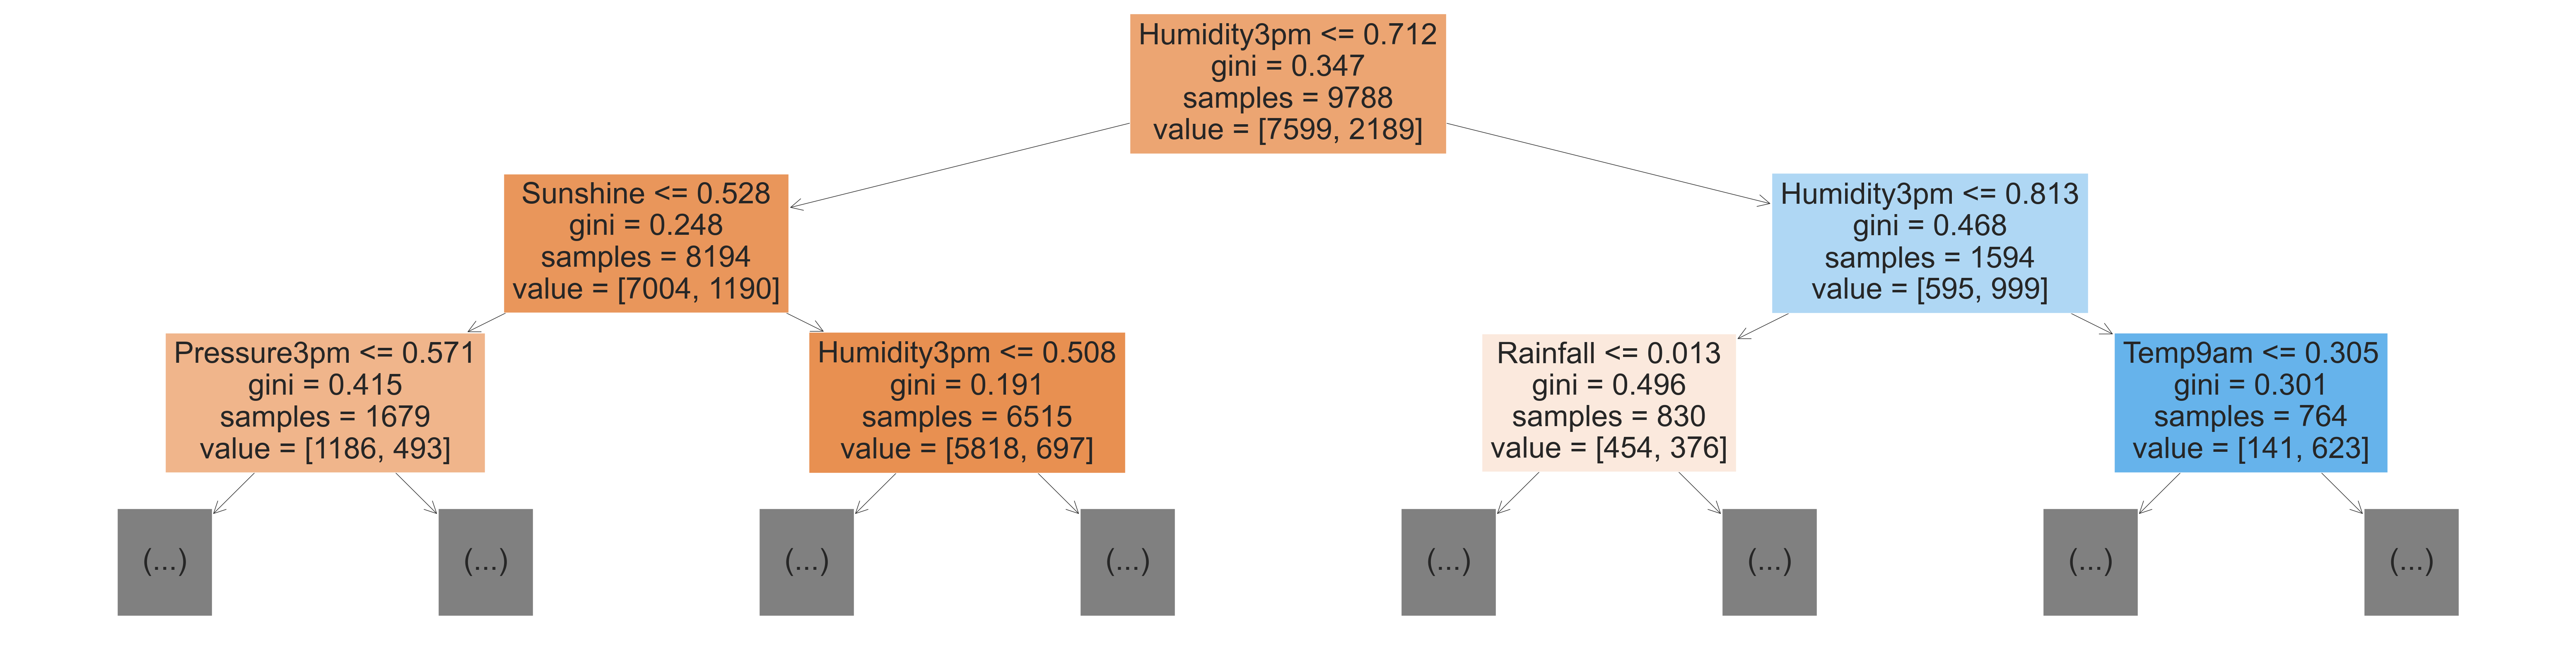

In [19]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names= X_train.columns, max_depth=2, filled=True)

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. "Gini" is a selection criteria or tree splitting criteria. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. "A lower Gini index indicates a better split(result). among the available columns." A perfect split (only one class on each side) has a Gini index of 0. If there is 50-50 split then the criteria is least prefered by the model itself because it's a bad criteria.

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://i.imgur.com/tlYiXnp.png" width="480">


Let's check the depth of the tree that was created.

In [20]:
model.tree_.max_depth

30

We can also display the tree as text, which can be easier to follow for deeper trees.

In [21]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.71
|   |--- Sunshine <= 0.53
|   |   |--- Pressure3pm <= 0.57
|   |   |   |--- Humidity3pm <= 0.56
|   |   |   |   |--- WindGustSpeed <= 0.33
|   |   |   |   |   |--- Location_Albany <= 0.50
|   |   |   |   |   |   |--- Sunshine <= 0.00
|   |   |   |   |   |   |   |--- WindDir3pm_N <= 0.50
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindDir3pm_N >  0.50
|   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Sunshine >  0.00
|   |   |   |   |   |   |   |--- WindDir3pm_nan <= 0.50
|   |   |   |   |   |   |   |   |--- WindSpeed9am <= 0.05
|   |   |   |   |   |   |   |   |   |--- WindDir3pm_NW <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- WindDir3pm_NW >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindSpeed9am >  0.05
|   |   |   |   |   |   |   |   |   |--- WindGustDir_NW <= 0.50
|   |   |   |   |  

##### Why Overfitting or 100% training accuracy?

The training accuracy is 100% because the decision tree has (our model) has literally memorized the entire training set in the form of this tree based structure.

And when it sees any example other than trainingor which doesn't fit exactly to the training, it tries to categorize it into one of the existing training examples by following one path of DT. That may or may not end up really well because it's going to ultimately boil down to a specific training example and doesn't generalize well to the examples it hasn't seen before.

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [22]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW',
       'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan',
       'RainToday_No', 'RainToday_Yes'],
      dtype='object', length=118)

In [23]:
model.feature_importances_

array([3.49257345e-02, 3.07937151e-02, 4.22748141e-02, 1.86728347e-02,
       5.44097237e-02, 5.15867301e-02, 2.12312331e-02, 2.87536812e-02,
       3.68257188e-02, 2.64559367e-01, 4.61709226e-02, 6.74395647e-02,
       1.73926170e-02, 1.25463339e-02, 3.30940709e-02, 2.81314210e-02,
       2.53636257e-03, 4.88594907e-03, 8.85196443e-05, 5.58347395e-04,
       2.17801237e-03, 1.72048150e-03, 1.79704909e-03, 8.80837628e-04,
       1.85616582e-03, 6.79028712e-04, 5.48664767e-04, 1.60682190e-03,
       3.36763438e-03, 7.65438990e-04, 1.33296623e-03, 1.76337264e-03,
       0.00000000e+00, 2.89718184e-03, 1.15398601e-03, 1.04335506e-03,
       1.42614666e-04, 9.47687991e-04, 8.43648412e-05, 2.30446882e-03,
       6.13116680e-04, 7.75828463e-04, 8.40861880e-04, 3.19148702e-03,
       2.03150657e-03, 1.95633156e-03, 8.01171026e-04, 5.46423397e-04,
       0.00000000e+00, 4.47298844e-03, 1.36814558e-03, 0.00000000e+00,
       1.17777289e-03, 1.32691363e-03, 1.41449744e-03, 1.08994330e-03,
      

Let's turn this into a dataframe and visualize the most important features.

In [24]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [25]:
importance_df

,feature,importance
9,Humidity3pm,0.264559
11,Pressure3pm,0.067440
4,Sunshine,0.054410
5,WindGustSpeed,0.051587
10,Pressure9am,0.046171
2,Rainfall,0.042275
8,Humidity9am,0.036826
0,MinTemp,0.034926
14,Temp9am,0.033094
1,MaxTemp,0.030794


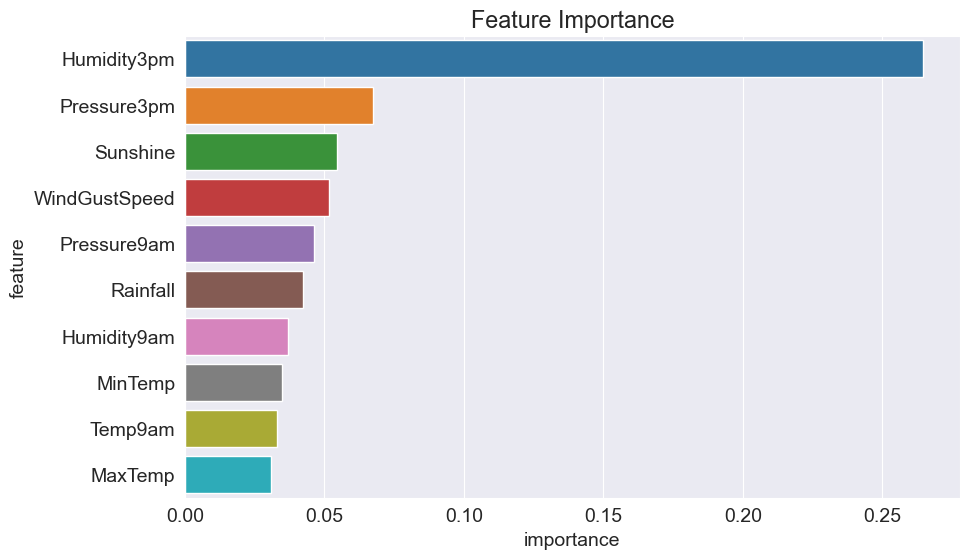

In [26]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. 


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`


### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [27]:
model = DecisionTreeClassifier(max_depth= 3, random_state= 42)

model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [28]:
print("Training Score: ", model.score(X_train, train_targets))
print("Validation Score: ", model.score(X_val, val_targets))

Training Score:  0.8338782182263996
Validation Score:  0.8470588235294118


Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [29]:
model.classes_

array(['No', 'Yes'], dtype=object)

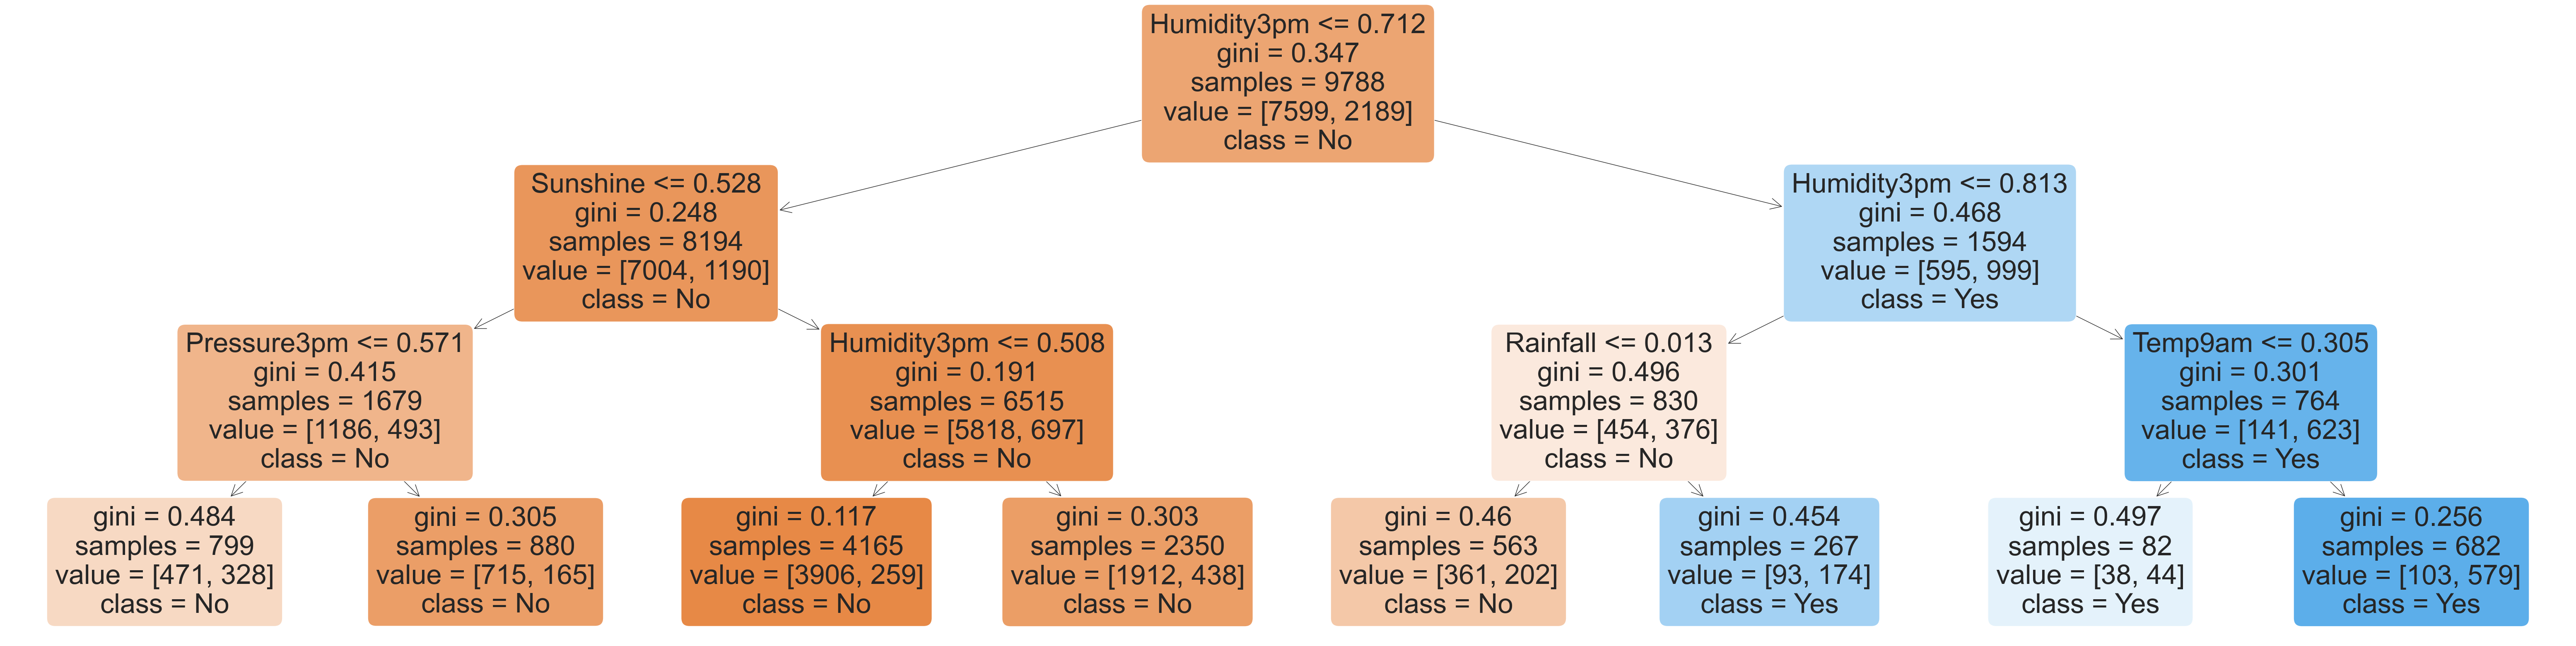

In [30]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [31]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.71
|   |--- Sunshine <= 0.53
|   |   |--- Pressure3pm <= 0.57
|   |   |   |--- class: No
|   |   |--- Pressure3pm >  0.57
|   |   |   |--- class: No
|   |--- Sunshine >  0.53
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- class: No
|--- Humidity3pm >  0.71
|   |--- Humidity3pm <= 0.81
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.81
|   |   |--- Temp9am <= 0.30
|   |   |   |--- class: Yes
|   |   |--- Temp9am >  0.30
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.


In [39]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    validation_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 
            'Validation Error': validation_error}
    

In [40]:
error_df = pd.DataFrame([max_depth_error(md) for md in range (1,21)])

In [41]:
error_df

,Max Depth,Training Error,Validation Error
0,1,0.182366,0.168235
1,2,0.174397,0.156471
2,3,0.166122,0.152941
3,4,0.162239,0.159412
4,5,0.155190,0.154706
5,6,0.142113,0.159412
6,7,0.130159,0.155294
7,8,0.117184,0.158824
8,9,0.104618,0.164706
9,10,0.090928,0.165882


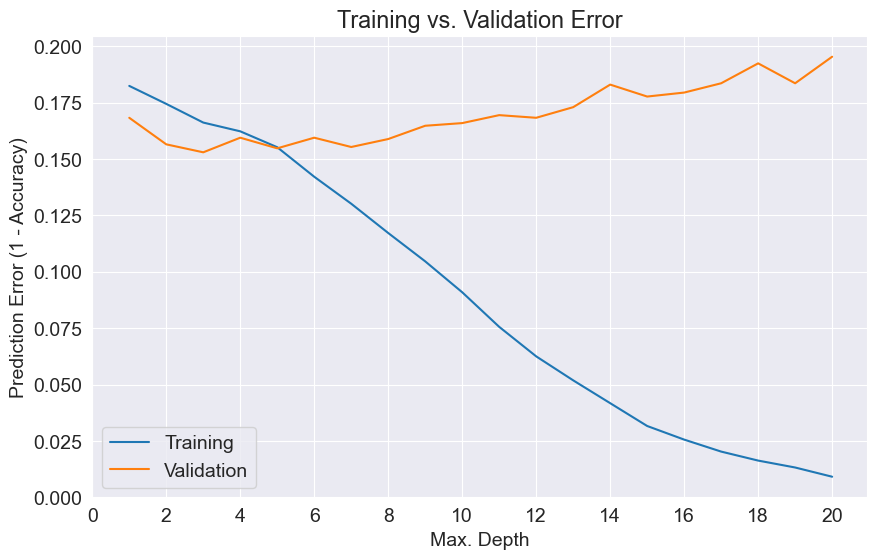

In [35]:
plt.figure()
plt.plot(error_df['Max Depth'], error_df['Training Error'])
plt.plot(error_df['Max Depth'], error_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 3 results in the lowest validation error.

In [42]:
model = DecisionTreeClassifier(max_depth=3, random_state= 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8338782182263996, 0.8470588235294118)

In [43]:
model = DecisionTreeClassifier(max_depth=5, random_state= 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8448099713935431, 0.8452941176470589)

In [44]:
model = DecisionTreeClassifier(max_depth=7, random_state= 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8698406211687781, 0.8447058823529412)

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

max_leaf_nodes = 2^n

example, 2^7 = 128

In [45]:
model = DecisionTreeClassifier(max_leaf_nodes= 8, random_state= 42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=8, random_state=42)

In [47]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8338782182263996, 0.8470588235294118)

In [50]:
model.tree_.max_depth

4

Notice that the model was able to achieve a greater depth of 4 for certain paths while keeping other paths shorter.

In [53]:
model_text = export_text(model, feature_names= list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.71
|   |--- Sunshine <= 0.53
|   |   |--- Pressure3pm <= 0.57
|   |   |   |--- class: No
|   |   |--- Pressure3pm >  0.57
|   |   |   |--- class: No
|   |--- Sunshine >  0.53
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- WindGustSpeed <= 0.38
|   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  0.38
|   |   |   |   |--- class: No
|--- Humidity3pm >  0.71
|   |--- Humidity3pm <= 0.81
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.81
|   |   |--- class: Yes



Let's check the combination of `max_depth` and `max_leaf_nodes` that results in the highest validation accuracy.

In [54]:
model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=8, random_state= 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8338782182263996, 0.8470588235294118)

In [55]:
model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes= 128, random_state= 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8698406211687781, 0.8435294117647059)

Explore and experiment with other arguments of `DecisionTree`. Refer to the docs for details: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd".

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [56]:
from sklearn.ensemble import RandomForestClassifier

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [57]:
model = RandomForestClassifier(n_jobs= -1, random_state= 42)
model.fit(X_train,train_targets)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [59]:
model.score(X_train,train_targets), model.score(X_val,val_targets)

(1.0, 0.8611764705882353)

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [60]:
train_probs  = model.predict_proba(X_train)
train_probs

array([[0.87, 0.13],
       [0.88, 0.12],
       [0.98, 0.02],
       ...,
       [0.9 , 0.1 ],
       [0.96, 0.04],
       [0.98, 0.02]])

We can can access individual decision trees using `model.estimators_`

In [62]:
model.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

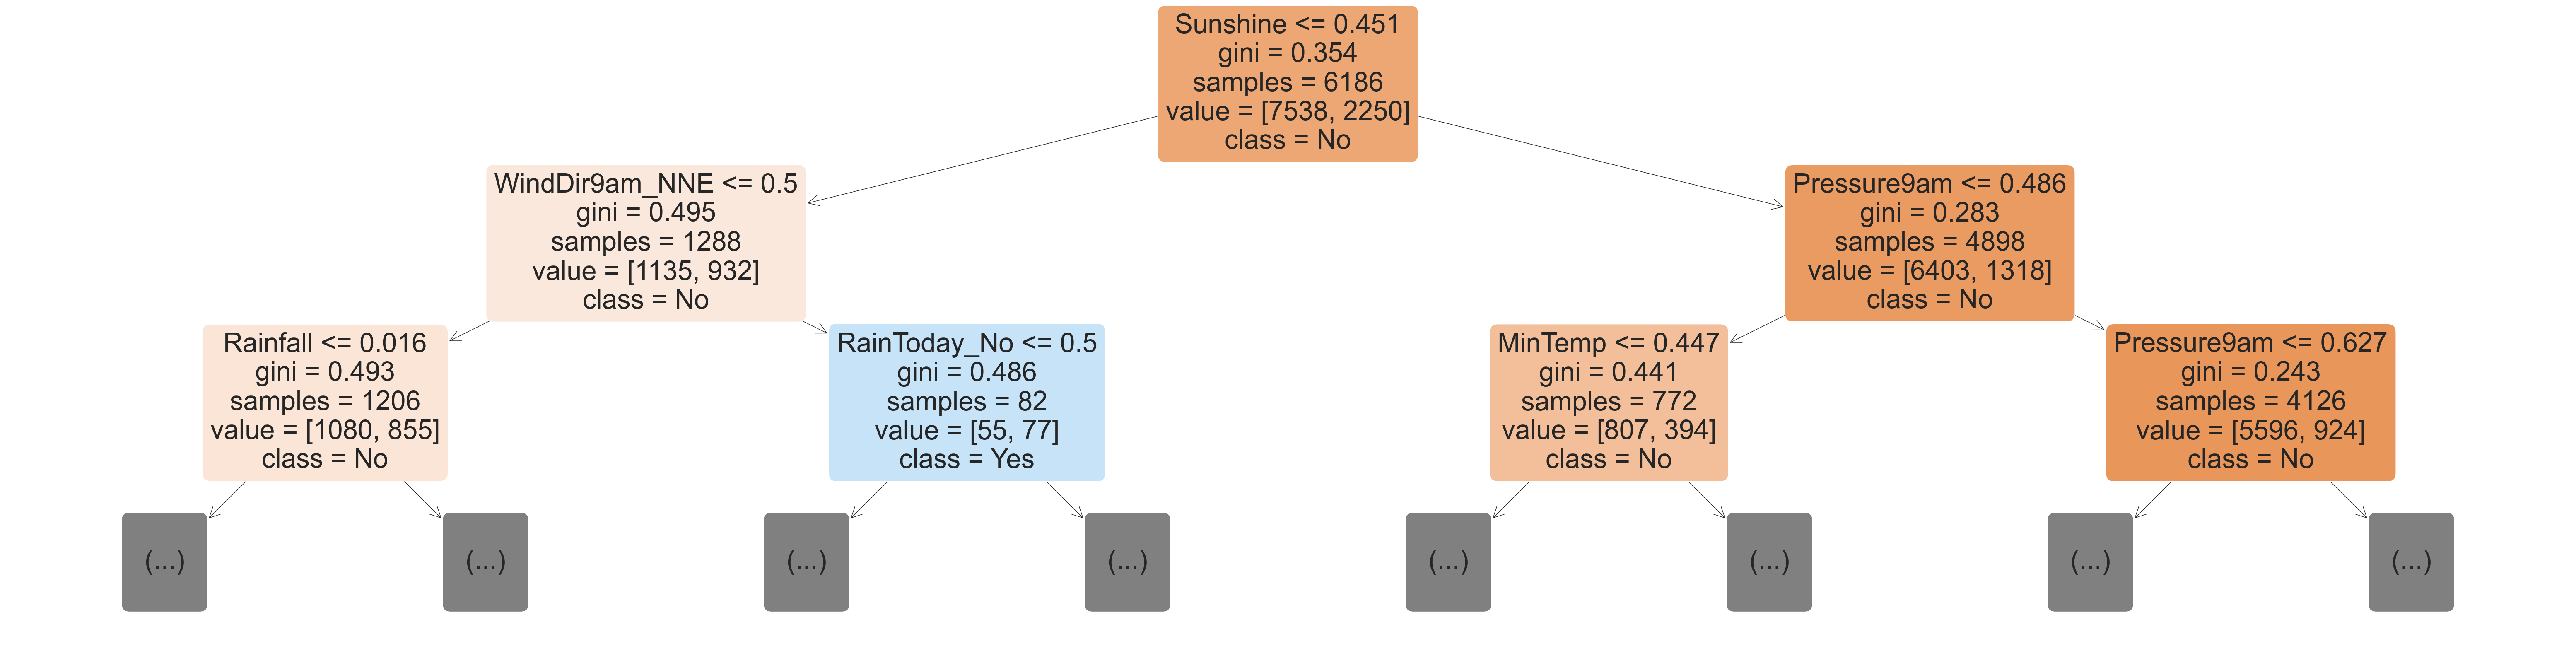

In [63]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

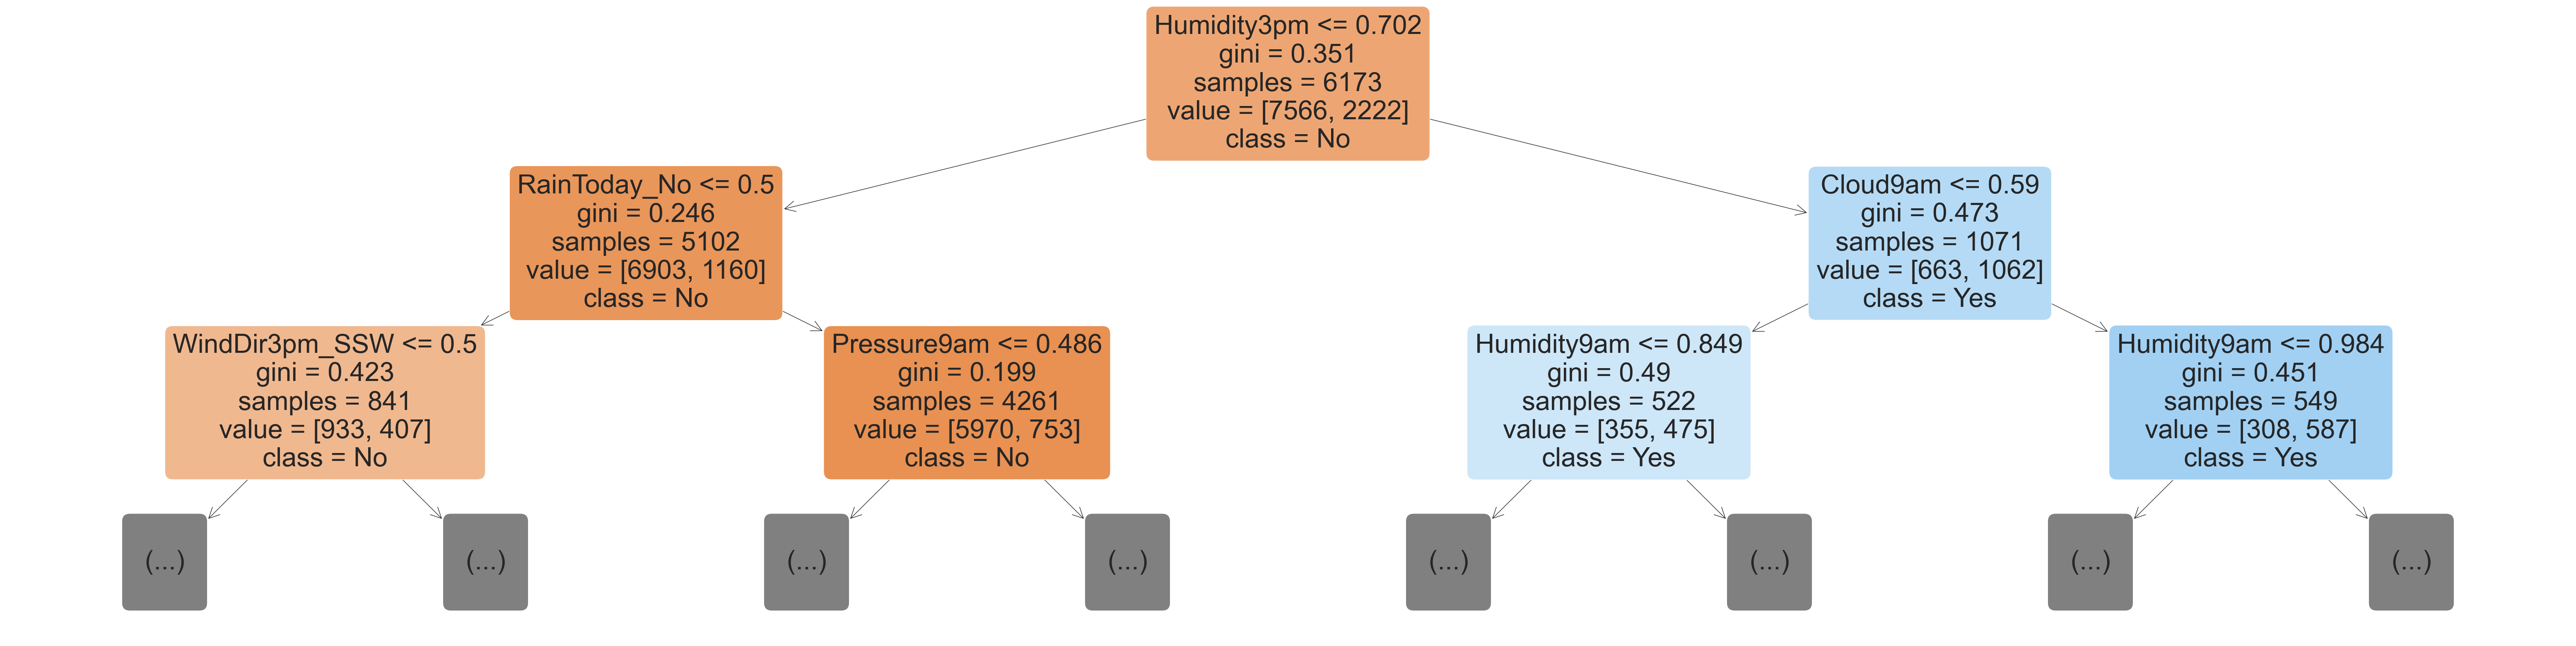

In [64]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[15], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [65]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df

,feature,importance
9,Humidity3pm,0.123956
4,Sunshine,0.057400
11,Pressure3pm,0.051902
10,Pressure9am,0.049768
2,Rainfall,0.049051
8,Humidity9am,0.048557
5,WindGustSpeed,0.046645
15,Temp3pm,0.043211
1,MaxTemp,0.041805
0,MinTemp,0.040839


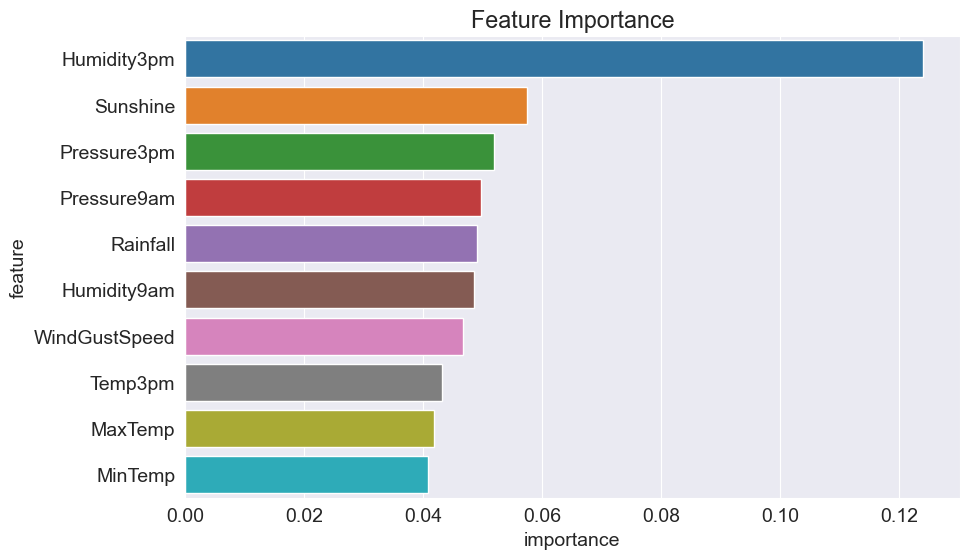

In [68]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's create a base model with which we can compare models with tuned hyperparameters.

In [69]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)
base_train_accuracy = base_model.score(X_train, train_targets)
base_val_accuracy = base_model.score(X_val, val_targets)
base_accuracies = base_train_accuracy, base_val_accuracy
base_accuracies

(1.0, 0.8611764705882353)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 

Note: Randomness helps reduce overfitting. More randomness, less overfitting.

**10 estimators**

In [70]:
model = RandomForestClassifier(random_state= 42, n_jobs= -1, n_estimators=10)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [73]:
print(base_accuracies)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(1.0, 0.8611764705882353)


(0.9871270944013077, 0.8470588235294118)

**500 estimators**

In [74]:
model = RandomForestClassifier(random_state= 42, n_jobs= -1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [75]:
print(base_accuracies)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(1.0, 0.8611764705882353)


(1.0, 0.8641176470588235)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [76]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`. 

In [78]:
test_params(max_depth = 5)

(0.8314262362076011, 0.8370588235294117)

In [80]:
test_params(max_depth = 26)

(0.9989783408255006, 0.8658823529411764)

In [81]:
test_params(max_leaf_nodes=2**5)

(0.8400081732733959, 0.84)

In [82]:
test_params(max_leaf_nodes=2**20)

(1.0, 0.8647058823529412)

In [83]:
test_params(max_depth = 26, max_leaf_nodes = 2**20)

(0.998467511238251, 0.8658823529411764)

In [84]:
base_accuracies # no max depth or max leaf nodes

(1.0, 0.8611764705882353)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [85]:
test_params(max_features = 'log2')

(1.0, 0.8558823529411764)

In [86]:
test_params(max_features=3)

(1.0, 0.8564705882352941)

In [93]:
test_params(max_features=10)

(1.0, 0.8611764705882353)

In [88]:
base_accuracies

(1.0, 0.8611764705882353)

In [98]:
test_params(min_samples_split=2)

(1.0, 0.8611764705882353)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.


In [99]:
test_params(min_impurity_decrease = 1e-7)

(1.0, 0.861764705882353)

In [106]:
test_params(min_impurity_decrease = 1e-9)

(1.0, 0.8629411764705882)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [107]:
test_params(bootstrap = False)

(1.0, 0.8582352941176471)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [110]:
test_params(max_samples = .9)

(1.0, 0.8635294117647059)

Learn more about bootstrapping here: https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

### `class_weight`

In [111]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [112]:
test_params(class_weight='balanced')

(1.0, 0.8570588235294118)

In [113]:
test_params(class_weight={'No': 1, 'Yes': 2})

(1.0, 0.8611764705882353)

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using a google or excel sheet.


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [119]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=10,
                               max_depth=26, 
                               class_weight={'No': 1, 'Yes': 1.5})

In [120]:
model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=26,
                       max_features=10, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [121]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9996935022476502, 0.8623529411764705)

In [118]:
base_accuracies

(1.0, 0.8611764705882353)

We've increased the accuracy from 80.58% with a single decision tree to 86.23% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

There are several possible reasons for the observed limitations in our model's performance:

* We might not have identified the optimal combination of hyperparameters to effectively regularize the model and reduce overfitting. Further exploration in this regard is warranted.

* The current modeling technique, Random Forests, may have reached its effectiveness limits. Exploring alternative methods, such as gradient boosting, could lead to improved results.

* Insufficient data might be a limiting factor. Acquiring more data could potentially enhance the model's predictive capabilities.

* The predictive accuracy may be constrained by the available features. Considering additional features or engaging in feature engineering might offer avenues for improvement.

* Predicting whether it will rain tomorrow could be inherently challenging due to the inherent randomness or chaotic nature of weather phenomena. This may impose a fundamental limit on the accuracy achievable with the given data and modeling techniques.

It's important to acknowledge that no model is perfect. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

Finally, let's also compute the accuracy of our model on the test set.

In [122]:
model.score(X_test, test_targets)

0.8340409108452335

Notice that the test accuracy is lower

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

## Summary and References

The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting & hyperparameter tuning
- Making predictions on single inputs



We also introduced the following terms:

* Decision tree
* Random forest
* Overfitting
* Hyperparameter
* Hyperparameter tuning
* Ensembling
* Generalization
* Bootstrapping


Check out the following resources to learn more: 

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
- https://www.kaggle.com/c/home-credit-default-risk/discussion/64821